<a href="https://colab.research.google.com/github/aryashivakumar/dataScience/blob/main/Unit5/AryaKumarU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section I: Introduction**

For my Unit 5 Project I will be using a linear model in order to predict Salary in thousands based on Experience in months. This data is sourced from Saquib Hussain on Kaggle. They sourced this data from  "work experience (in months) and corresponding monthly salaries (in thousand dollars) of employees across various industries"

This is important so that if someone concerned about how much they could make wiht a certain amount of experience (for example an internship), they could clearly see what their potential pay may be in thousands for a job.

Lets go!

In [ ]:

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import graphviz as gv

from scipy.interpolate import PchipInterpolator

# **Section II: Data**

Data sourced from Kaggle: https://www.kaggle.com/datasets/saquib7hussain/experience-salary-dataset

In [ ]:
url_Salary = 'https://raw.githubusercontent.com/aryashivakumar/dataScience/refs/heads/main/Unit5/Monthly%20Experience%20vs%20Salary%20-%20Sheet1.csv'
#I could have put the url string directly into pd.read_csv()
Salary = pd.read_csv(url_Salary)


In [ ]:
Salary

,Experience,Salary
0,18.290293,16.521825
1,17.023407,11.666234
2,26.343613,23.167255
3,19.105834,20.877145
4,27.742516,23.166236
...,...,...
995,22.161741,24.666502
996,32.266497,24.160270
997,17.039030,19.903797
998,25.222124,21.974413


<Axes: xlabel='Experience', ylabel='Salary'>

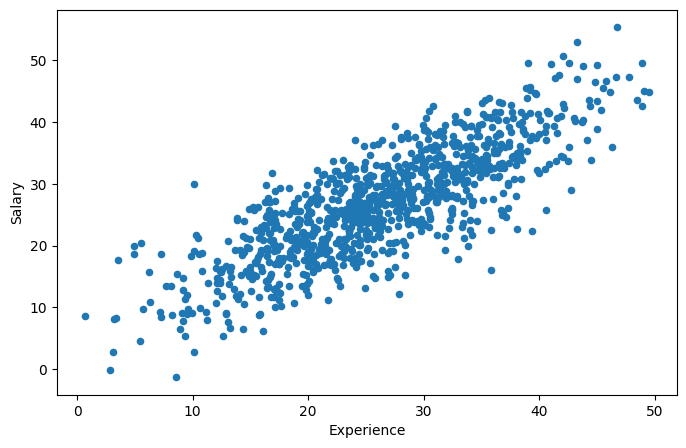

In [ ]:
Salary.plot(x="Experience", y = "Salary", figsize=(8, 5) , kind="scatter")

The scaterplot shows us that there seems to be a linear relationship between Experience in months and Salary in thousands. Lets proceed.

# **Section III: Linear Model**


In [ ]:
#nh for non hierarchical
with pm.Model() as nh_model:
    #priors
    α = pm.Normal("α", mu=0, sigma=3)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α + β * Salary['Experience'],
                  sigma=σ,
                  observed=Salary['Salary'])
    idata_nh_b = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_nh_b, model=nh_model,  extend_inferencedata=True)

Text(0, 0.5, 'Salary')

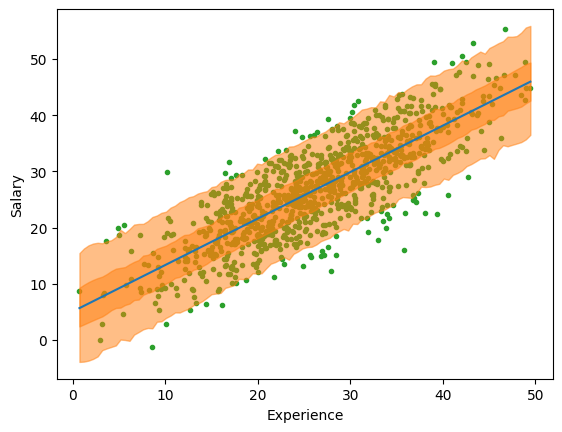

In [ ]:
#plots the posterior predictive distribution

# Create a range of x values for plotting the regression line
experience_values = Salary['Experience'].values
idx = np.argsort(experience_values)
x = np.linspace(experience_values.min(), experience_values.max(), 100) # 100 points for a smooth line

# Get posterior samples for alpha and beta
alpha_posterior = idata_nh_b.posterior["α"]
beta_posterior = idata_nh_b.posterior["β"]

# Calculate the expected mean (mu) for each posterior sample across the x range
# This involves broadcasting: (num_chains, num_draws, 1) + (num_chains, num_draws, 1) * (1, 1, len(x))
# The result will be (num_chains, num_draws, len(x))
mu_posterior_pred = alpha_posterior.values[:, :, None] + beta_posterior.values[:, :, None] * x[None, None, :]

# Calculate the mean of these predictions across chains and draws
mean_line = np.mean(mu_posterior_pred, axis=(0, 1))

# grabs the 94% HDI and 50% HDI
y_pred_q = idata_nh_b.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds_list = []
for i in range(4):
    # Ensure both experience_values[idx] and y_pred_q[i].values[idx] are sorted in the same way
    interpolator = PchipInterpolator(experience_values[idx], y_pred_q[i].values[idx])
    y_hat_bounds_list.append(interpolator(x)) # Interpolate over the new, smooth 'x' values

y_hat_bounds = iter(y_hat_bounds_list)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(Salary['Experience'], Salary['Salary'], "C2.", zorder=-3) # Use Salary data
ax.plot(x, mean_line, c="C0") # Plot against new x and calculated mean_line

#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Experience")
ax.set_ylabel("Salary")

This shows there is no doubt that Experience and Salary is connected as there is a straight light w/ a slope in the 94% HDI.

In [ ]:
pm.sample_posterior_predictive(idata_nh_b, model=nh_model,  extend_inferencedata=True)

<Axes: xlabel='y_pred'>

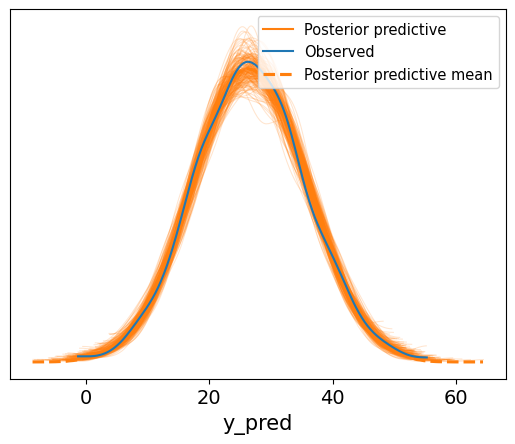

In [ ]:
az.plot_ppc(idata_nh_b, num_pp_samples=200, colors=["C1", "C0", "C1"])

The posterior predictive to observed check is very good. Both tails are very well mached, and the cental peak is accounted for (normal curve). This model does a pretty good job!